In [ ]:
import os
import torch
from torch import nn
import torch.utils.data as data
import torch.optim as optim


import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from collections import OrderedDict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/datasets/cartoons_jpg'
files = os.listdir(path)
files = [os.path.join(path, f) for f in files]

(500, 500, 3)


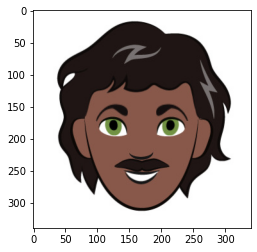

In [ ]:
img = plt.imread(files[0])
print(img.shape)
plt.imshow(img[80:-80,80:-80,:])

2001
1601
1600


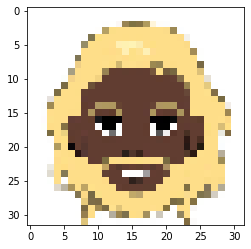

In [ ]:
images = []
for p in files:
  img = plt.imread(p)[80:-80,80:-80,:]
  images.append(cv2.resize(img, (32, 32)))
  if len(images) > 2000: break

train = np.array(images[int(len(images)*0.2):])
test = np.array(images[:int(len(images)*0.8)])


print(len(images))
print(len(train))
print(len(test))
plt.imshow(train[32])

In [ ]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_shape = output_shape

        # (3, 32, 32) - > 4,4, -> 16
        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(latent_dim, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        out = self.deconvs(out)
        return out


class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim # 16
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        # 4 x 4 x 256
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        # 4 x 4 x 256, 2 * 16
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        out = self.convs(x) 
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1) 
        return mu, log_std


class ConvVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.latent_size = latent_size
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = ConvDecoder(latent_size, input_shape)

    def loss(self, x):
        x = 2 * x - 1 # ?
        mu, log_std = self.encoder(x)
        #z = torch.randn_like(mu) * log_std.exp() + mu
        z = torch.randn_like(mu) + mu #* log_std.exp() + mu
        x_recon = self.decoder(z)

        recon_loss = torch.pow(x -  x_recon, 2).view(x.shape[0], -1).sum(1).mean()
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda()
            samples = torch.clamp(self.decoder(z), -1, 1)
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

In [ ]:
torch.cuda.current_device()

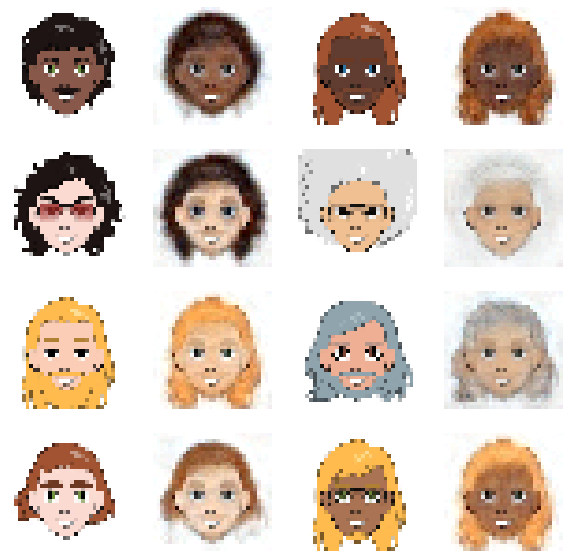

In [ ]:
"""
  train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
  test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
    and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
  - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
    and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
  - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
  - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
    FROM THE TEST SET with values in {0, ..., 255}
  - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
    pairs of test images. The output should be those 100 images flattened into
    the specified shape with values in {0, ..., 255}
  """

""" YOUR CODE HERE """

def plot_samples(epoch, test_output):
  predictions = test_output # model.sample(test_input)
  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i])
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  display.clear_output(wait=False)
  plt.show()

def train_step(model, train_loader, optimizer, epoch, quiet, grad_clip=None):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses

def eval_loss(model, data_loader, quiet):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses

def train_epochs(model, train_loader, test_loader, train_args, quiet=False):
  epochs, lr = train_args['epochs'], train_args['lr']
  grad_clip = train_args.get('grad_clip', None)
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses, test_losses = OrderedDict(), OrderedDict()
  for epoch in range(epochs):
      model.train()
      train_loss = train_step(model, train_loader, optimizer, epoch, quiet, grad_clip)
      test_loss = eval_loss(model, test_loader, quiet)

      for k in train_loss.keys():
          if k not in train_losses:
              train_losses[k] = []
              test_losses[k] = []
          train_losses[k].extend(train_loss[k])
          test_losses[k].append(test_loss[k])
       
 
      x = next(iter(test_loader))[:8].cuda()
      with torch.no_grad():
          x = 2 * x - 1
          z, _ = model.encoder(x)
          x_recon = torch.clamp(model.decoder(z), -1, 1)
      reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
      reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() #* 255
      plot_samples(epoch, reconstructions)
        
  return train_losses, test_losses


train_data = (np.transpose(train, (0, 3, 1, 2)) / 255.).astype('float32')
test_data = (np.transpose(test, (0, 3, 1, 2)) / 255.).astype('float32')

model = ConvVAE((3, 32, 32), 8).cuda()

train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=128)

train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                          dict(epochs=30, lr=1e-3), quiet=True)

train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)


In [ ]:
samples = model.sample(100) * 255.
x = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    x = 2 * x - 1
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() #* 255

x = next(iter(test_loader))[2:16].cuda()
with torch.no_grad():
    x = 2 * x - 1
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 16)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.permute(0, 2, 3, 1).cpu().numpy() #* 255

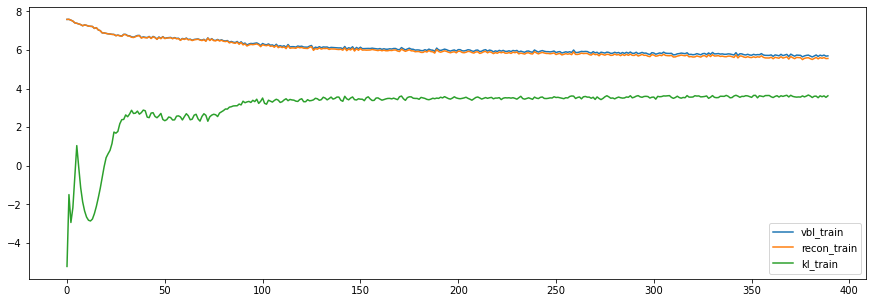

In [ ]:
plt.figure(figsize=(15,5))

for i, l in zip([0,1,2],['vbl','recon','kl']):
    plt.plot(range(len(train_losses[:,i])),np.log(train_losses[:,i]), label=l+'_train')
plt.legend()
plt.show()

In [ ]:
train_losses[:,2].mean()

28.416104002995418

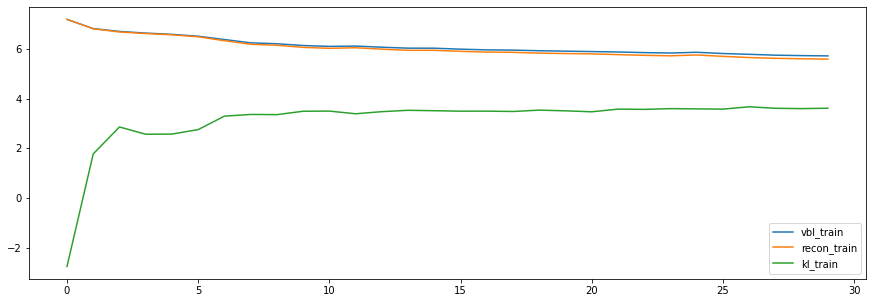

In [ ]:
plt.figure(figsize=(15,5))

for i, l in zip([0,1,2],['vbl','recon','kl']):
    plt.plot(range(len(test_losses[:,i])),np.log(test_losses[:,i]), label=l+'_train')
plt.legend()
plt.show()


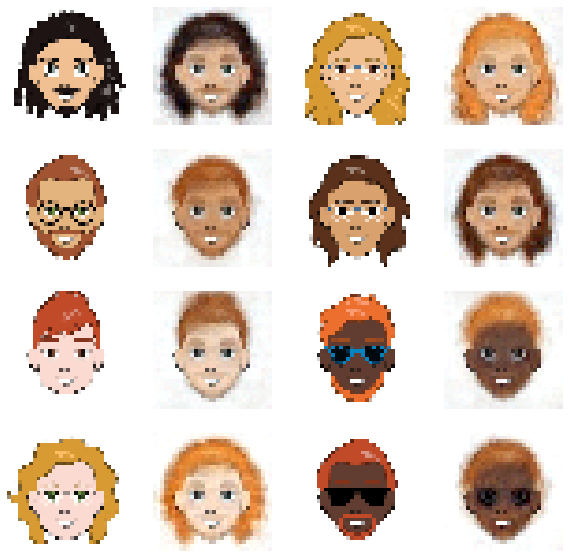

In [ ]:
plot_samples(0, reconstructions[16:32])


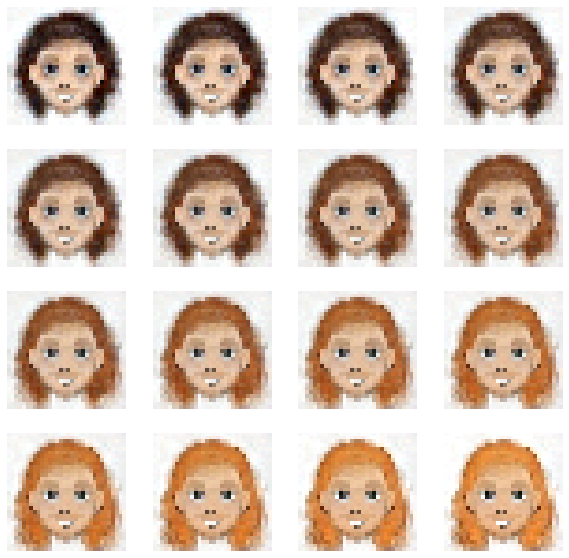

In [ ]:
plot_samples(0, interps[:16])